# Summarization Transformers Custom

Используем трансформер для извлечения abstract’а статьи (на базе научных статей)


# Setup & Import

In [ ]:
pathName      = "/content/drive/My Drive/" 
pathNameData  = pathName + "Datasets/" 
pathNameTrain = pathName + "DataTrain/"
prefix        = '_2022_'

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split
import unicodedata

import time

from tqdm.notebook import tqdm
import pickle

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### unrar

In [ ]:
path = pathNameData + 'статьи.rar'
#path = pathNameData + 'articals.rar'
!mkdir !
path_in = '/content/!/'

!unrar e '$path' '$path_in'

mkdir: cannot create directory ‘!’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/Datasets/статьи.rar


Would you like to replace the existing file /content/!/1.xlsx
 21140 bytes, modified on 2020-05-04 07:29
with a new one
 21140 bytes, modified on 2020-05-04 07:29

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/!/1.xlsx                                              0%  OK 
Extracting  /content/!/10.xlsx                                             0%  OK 
Extracting  /content/!/100.xlsx                                            0%  OK 
Extracting  /content/!/1000.xlsx                                           0%  OK 
Extracting  /content/!/101.xlsx                                            0%  OK 
Extracting  /content/!/102.xlsx                                            0%  OK 
Extracting  /content/!/103.xlsx                         

In [ ]:
# Тестовый прогон
#path = pathNameData + 'статьи.rar'
path = '/content/' + 'articals.rar'
!mkdir !
path_in = '/content/!/'

!unrar e '$path' '$path_in'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/articals.rar

Extracting  /content/!/957.xlsx                                           11%  OK 
Extracting  /content/!/958.xlsx                                           17%  OK 
Extracting  /content/!/Эффективность комплексной нейрореабилитации.xlsx      31%  OK 
Extracting  /content/!/мед 121.ods                                        43%  OK 
Extracting  /content/!/мед 122.ods                                        54%  OK 
Extracting  /content/!/Модифицируемые.xlsx                                66%  OK 
Extracting  /content/!/434.xlsx                                           83%  OK 
Extracting  /content/!/575.xlsx                                           99%  OK 
All OK


In [ ]:
path_in = '/content/!/'
files_list = os.listdir(path_in)
len(files_list), files_list[:5]

(8, ['575.xlsx', '434.xlsx', 'мед 121.ods', '958.xlsx', 'Модифицируемые.xlsx'])

# Prepare & Explore Data

### Parse .xlsx, .ods

In [ ]:
cols =['name', 'absract', 'intro', 'materias_methods', 'discussion', 'results']
lst = { cols[i]:"" for i in range(len(cols)) }
lst

{'absract': '',
 'discussion': '',
 'intro': '',
 'materias_methods': '',
 'name': '',
 'results': ''}

In [ ]:
def xlsxToDict(fn):
  pd_excl = pd.read_excel(fn, na_values=None,  header= None, )
  cols =['name', 'absract', 'intro', 'materias_methods', 'discussion', 'results']
  lst = { cols[i]:"" for i in range(len(cols)) }
  j = -1
  for i, row in enumerate(pd_excl.iterrows()):
    
    r0, r1 = row[1][0], row[1][1]
    t = type(r0)
    if isinstance(r0, str):
      #print("type:", t)
      j = j+1
      if isinstance(r1, str):
        lst[cols[j]] = lst[cols[j]] + row[1][1]
      #try:
        #lst[cols[j]] = lst[cols[j]] + row[1][1]
      #except:
      #  print(i, j, fn)
      #print (r0, " :  ", r1)
    
  return lst
  
#xlsxToDict (path_in + '957.xlsx')  
#_= xlsxToDict (path_in + '434.xlsx')  
#xlsxToDict (path_in + '434.xlsx')  
xlsxToDict (path_in + '575.xlsx')  

{'absract': 'В статье представлен обзор современной российской и зарубежной литературы, посвященной проблеме патогенеза, лечения и профилактики антибиотик-ассоциированной диареи. Антибиотик-ассоциированная диарея представляет собой один из наиболее актуальных аспектов современной фармакотерапии в связи с частым назначением антибактериальных препаратов. Под антибиотик-ассоциированной диареей (согласно ВОЗ) понимают наличие трех или более эпизодов неоформленного стула в течение двух или более последовательных дней, которые возникли во время или после окончания антибиотикотерапии. Риск развития этого расстройства наиболее высок при использовании аминопенициллинов, а также их комбинаций с клавулановой кислотой, цефалоспоринов, клиндамицина. Несмотря на наличие общего этиологического фактора — приема антибактериальных средств, непосредственные причины и механизмы развития антибиотик-ассоциированной диареи у пациентов могут быть различны. В статье рассматриваются основные вопросы этиологии и

In [ ]:
xlsxToDict (path_in + 'мед 122.ods')

{'absract': 'В настоящее время нет единого мнения о выборе тактики восстановительного лечения после операций на позвоночнике и крестце в онковертебрологии. Существуют отдельные протоколы по реабилитации, опубликованные крупными онкоортопедическими клиниками. В Российской Федерации таких работ в настоящее время нет. Проведен анализ функциональных результатов ранней послеоперационной реабилитации пациентов с поражением позвоночника и крестца, разработанной на основе международных рекомендаций. Полученные данные достоверно свидетельствуют об улучшении качества жизни, мобильности у пациентов, получивших комплексную реабилитацию, по сравнению с группой контроля, которой восстановительное лечение не проводилось. Проведение комплексной реабилитации значительно улучшают функциональные результаты хирургического лечения и качества жизни больных с опухолями позвоночника и крестца ',
 'discussion': nan,
 'intro': 'Метастатическое поражение костной системы занимает третье место по частоте после мет

In [ ]:
columns=['name', 'absract', 'intro', 'materias_methods', 'discussion', 'results']
df = pd.DataFrame(columns=columns)
from tqdm.notebook import tqdm
for fn in tqdm(files_list):
  if '.xlsx' in fn:
    df.loc[-1] = xlsxToDict (path_in + fn)        # adding a row
    df.index = df.index + 1                       # shifting index
  elif '.ods' in fn:             # Pandas  тоже читает '.ods'
    df.loc[-1] = xlsxToDict (path_in + fn)  
    df.index = df.index + 1  
  else:
    print(fn)
df = df.sort_index()
df    

  0%|          | 0/3201 [00:00<?, ?it/s]

.ipynb_checkpoints


,name,absract,intro,materias_methods,discussion,results
0,ОСОБЕННОСТИ ТЕЧЕНИЯ ОСТРЫХ РЕСПИРАТОРНЫХ ЗАБОЛ...,В работе определены клинико-иммунологические о...,Острые респираторные заболевания (ОРЗ) предста...,,,"В недавнем систематическом обзоре, в котором п..."
1,НЕЙРОФИЗИОЛОГИЧЕСКИЙ СТАТУС ПАЦИЕНТОВ С НЕКЛАП...,Цель Исследование имело целью изучение нейропс...,Фибрилляция предсердий (ФП) является наиболее ...,Пациенты и группа контроля В исследование был ...,Результаты настоящего исследования демонстриру...,Общий когнитивный статус и данные нейровизуали...
2,,,,,,
3,ПРОФИЛАКТИКА НАРУШЕНИЙ РЕПРОДУКТИВНОГО ЗДОРОВЬ...,На сегодняшний день одной из актуальных пробле...,Решение многих вопросов ювенильной гинекологии...,Обследовано 106 девушек в возрасте от 15 до 18...,,Основными жалобами у всех обследованных были б...
4,Изучение аминокислот грушанки круглолистной и ...,В статье представлены результаты изучения амин...,Грушанка круглолистная и ортилия однобокая – п...,Объектами нашего исследования послужили предст...,"Таким образом, в результате исследования вперв...","Полученные результаты показали, что из 26 амин..."
...,...,...,...,...,...,...
3195,Система антиоксидантной защиты на начальных ст...,Обследовано 109 пациентов с начальными проявле...,При разработке научных основ и практических ме...,Обследовано 109 пациентов с первичной ХЦВП при...,Повышение уровня ПОЛ при недостаточной активно...,По уровню повышения артериального давления (АД...
3196,,,,,,
3197,ПРОГНОСТИЧЕСКАЯ ЗНАЧИМОСТЬ СОДЕРЖАНИЯ БЕЛКА nm...,Цель. Изучение экспрессии белка nm 23 в первич...,Механизмы прогрессии злокачественных новообраз...,В исследование включен послеоперационный матер...,,При иммуногистохимическом исследовании первичн...
3198,,,,,,


In [ ]:
# замена NaN на " "
df.fillna(" ", inplace=True)
df.head()

,name,absract,intro,materias_methods,discussion,results
0,ОСОБЕННОСТИ ТЕЧЕНИЯ ОСТРЫХ РЕСПИРАТОРНЫХ ЗАБОЛ...,В работе определены клинико-иммунологические о...,Острые респираторные заболевания (ОРЗ) предста...,,,"В недавнем систематическом обзоре, в котором п..."
1,НЕЙРОФИЗИОЛОГИЧЕСКИЙ СТАТУС ПАЦИЕНТОВ С НЕКЛАП...,Цель Исследование имело целью изучение нейропс...,Фибрилляция предсердий (ФП) является наиболее ...,Пациенты и группа контроля В исследование был ...,Результаты настоящего исследования демонстриру...,Общий когнитивный статус и данные нейровизуали...
2,,,,,,
3,ПРОФИЛАКТИКА НАРУШЕНИЙ РЕПРОДУКТИВНОГО ЗДОРОВЬ...,На сегодняшний день одной из актуальных пробле...,Решение многих вопросов ювенильной гинекологии...,Обследовано 106 девушек в возрасте от 15 до 18...,,Основными жалобами у всех обследованных были б...
4,Изучение аминокислот грушанки круглолистной и ...,В статье представлены результаты изучения амин...,Грушанка круглолистная и ортилия однобокая – п...,Объектами нашего исследования послужили предст...,"Таким образом, в результате исследования вперв...","Полученные результаты показали, что из 26 амин..."


In [ ]:
#df.inputs = df.apply(lambda x: " ".join(df[col]) for col in cols_inputs)
#df['inputs'] = df[cols_inputs].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
#df['inputs'] = df[cols_inputs].apply(lambda row: ' '.join( row.values.astype(str)[::-1]), axis=1)
df['inputs'] = df[cols_inputs].apply(lambda row: ' '.join( row.values), axis=1)
df.head() #.inputs

,name,absract,intro,materias_methods,discussion,results,inputs
0,ОСОБЕННОСТИ ТЕЧЕНИЯ ОСТРЫХ РЕСПИРАТОРНЫХ ЗАБОЛ...,В работе определены клинико-иммунологические о...,Острые респираторные заболевания (ОРЗ) предста...,,,"В недавнем систематическом обзоре, в котором п...",ОСОБЕННОСТИ ТЕЧЕНИЯ ОСТРЫХ РЕСПИРАТОРНЫХ ЗАБОЛ...
1,НЕЙРОФИЗИОЛОГИЧЕСКИЙ СТАТУС ПАЦИЕНТОВ С НЕКЛАП...,Цель Исследование имело целью изучение нейропс...,Фибрилляция предсердий (ФП) является наиболее ...,Пациенты и группа контроля В исследование был ...,Результаты настоящего исследования демонстриру...,Общий когнитивный статус и данные нейровизуали...,НЕЙРОФИЗИОЛОГИЧЕСКИЙ СТАТУС ПАЦИЕНТОВ С НЕКЛАП...
2,,,,,,,
3,ПРОФИЛАКТИКА НАРУШЕНИЙ РЕПРОДУКТИВНОГО ЗДОРОВЬ...,На сегодняшний день одной из актуальных пробле...,Решение многих вопросов ювенильной гинекологии...,Обследовано 106 девушек в возрасте от 15 до 18...,,Основными жалобами у всех обследованных были б...,ПРОФИЛАКТИКА НАРУШЕНИЙ РЕПРОДУКТИВНОГО ЗДОРОВЬ...
4,Изучение аминокислот грушанки круглолистной и ...,В статье представлены результаты изучения амин...,Грушанка круглолистная и ортилия однобокая – п...,Объектами нашего исследования послужили предст...,"Таким образом, в результате исследования вперв...","Полученные результаты показали, что из 26 амин...",Изучение аминокислот грушанки круглолистной и ...


In [ ]:
cols_inputs = ['name', 'intro', 'materias_methods', 'discussion', 'results']
cols_targets = ['absract']
inputs = df[cols_inputs].to_numpy()
inputs_concat = df['inputs'].to_numpy()
inputs_concat 
targets = df[cols_targets].to_numpy().reshape(-1)
targets

array(['В работе определены клинико-иммунологические особенности течения ОРВИ у больных с атопиями и проведена оценка клинической эффективности трансфер фактора у больных с выраженной иммунной недостаточностью. Подчеркнута роль респираторных инфекций как важнейших триггеров обострений атопий и причины их более тяжелого и длительного течения. Описаны механизмы того, как респираторные вирусы потенцируют хроническое воспаление и ремоделирование дыхательных путей. Роль возбудителей ОРВИ у больных с атопиями заслуживает большего практического внимания и на пути к оптимизации терапии.',
       'Цель Исследование имело целью изучение нейропсихологических показателей, отражающих деятельность основных когнитивных доменов (нейродинамических функций, внимания и кратковременной памяти) и показателей электрической активности коры у пациентов с неклапанной фибрилляцией предсердий (ФП). Материалы и методы В исследование был включен 21 пациент с неклапанной ФП, госпитализированный в отделение рентгенх

In [ ]:
inputs[0]

array(['ОСОБЕННОСТИ ТЕЧЕНИЯ ОСТРЫХ РЕСПИРАТОРНЫХ ЗАБОЛЕВАНИЙ У БОЛЬНЫХ С АТОПИЯМИ',
       'Острые респираторные заболевания (ОРЗ) представляют собой большую этиологически разнородную группу инфекционных болезней, протекающих с поражением верхних дыхательных путей, трахеи и бронхов, характеризующихся определенным сходством патогенеза и клинических проявлений. В большинстве случаев (70–80%) респираторные заболевания обусловлены вирусной инфекцией. Медицинское и социально-экономическое значение этой патологии определяется масштабами распространенности и ее активной ролью в патогенезе многочисленных осложнений со стороны различных органов и систем. Одним из факторов риска рецидивов острых респираторных заболеваний и более тяжелого ее течения является аллергия. Аллергические заболевания представляют одну из трудноразрешимых и актуальных задач современной медицины. Мировая статистика доказывает стремительный рост такой патологии (до 20%). Сегодня каждый пятый житель на Земле страдает какой-

In [ ]:
inputs_concat [0][:5000]

'ОСОБЕННОСТИ ТЕЧЕНИЯ ОСТРЫХ РЕСПИРАТОРНЫХ ЗАБОЛЕВАНИЙ У БОЛЬНЫХ С АТОПИЯМИ Острые респираторные заболевания (ОРЗ) представляют собой большую этиологически разнородную группу инфекционных болезней, протекающих с поражением верхних дыхательных путей, трахеи и бронхов, характеризующихся определенным сходством патогенеза и клинических проявлений. В большинстве случаев (70–80%) респираторные заболевания обусловлены вирусной инфекцией. Медицинское и социально-экономическое значение этой патологии определяется масштабами распространенности и ее активной ролью в патогенезе многочисленных осложнений со стороны различных органов и систем. Одним из факторов риска рецидивов острых респираторных заболеваний и более тяжелого ее течения является аллергия. Аллергические заболевания представляют одну из трудноразрешимых и актуальных задач современной медицины. Мировая статистика доказывает стремительный рост такой патологии (до 20%). Сегодня каждый пятый житель на Земле страдает какой-либо формой атопи

In [ ]:
# посимвольная длина
inputs_concat_lens = [len(s) for s in inputs_concat]
print(max(inputs_concat_lens))
inputs_lens = [[len(s) for s in arr] for arr in inputs]
print(max(inputs_lens))
print(cols_inputs)
for l in inputs_lens[:5]:
  print(l)
print()
targets_lens = [len(s) for s in targets]
print('max(targets_lens)', max(targets_lens))

43420
[2217, 2982, 2920, 3641, 5759]
['name', 'intro', 'materias_methods', 'discussion', 'results']
[73, 3655, 0, 0, 15588]
[77, 2657, 5496, 3260, 3965]
[0, 0, 0, 0, 0]
[93, 3652, 1504, 0, 7287]
[63, 2670, 6618, 379, 1170]

max(targets_lens) 6924


In [ ]:
cols_inputs = ['name', 'intro', 'materias_methods', 'discussion', 'results']
cols_targets = ['absract']

In [ ]:
# пословная  длина
inputs_concat_lens_w = [len(s.split()) for s in inputs_concat]
print(max(inputs_concat_lens_w))
inputs_lens_w = [[len(s.split()) for s in arr] for arr in inputs ]
max_inputs_lens_w = [l[0] for l in inputs_lens_w]
print(max_inputs_lens_w)
print(cols_inputs)
for l in inputs_lens_w[:5]:
  print(l)
print()
targets_lens_w = [len(s.split()) for s in targets]
print('max(targets_lens_w)', max(targets_lens_w))

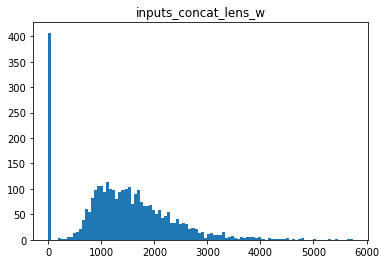

In [ ]:
plt.hist(inputs_concat_lens_w, bins=100)
plt.title('inputs_concat_lens_w')
plt.show()

In [ ]:
np.array(inputs_lens_w)[:,0]

array([ 9,  7,  0, ..., 10,  0,  8])

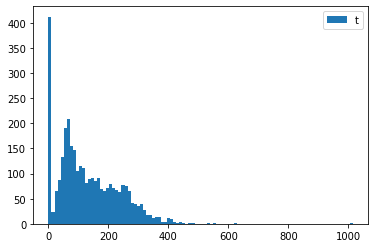

In [ ]:
plt.hist(targets_lens_w, bins=100)
plt.legend('targets_lens_w')
plt.show()

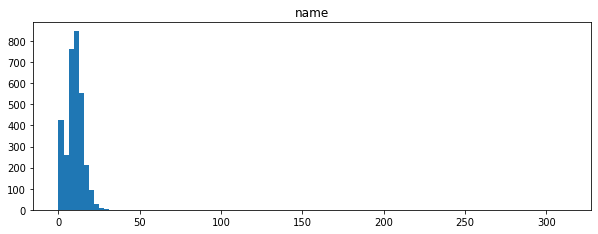

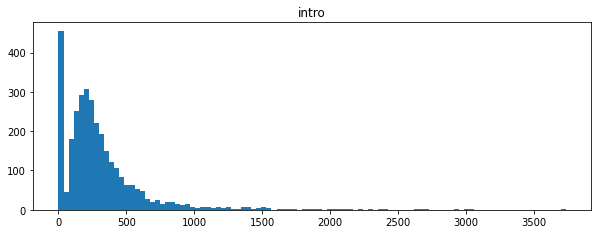

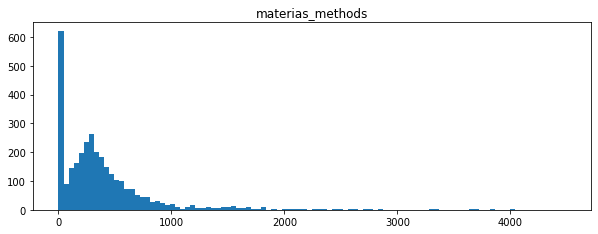

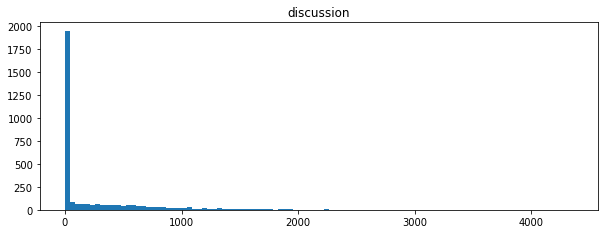

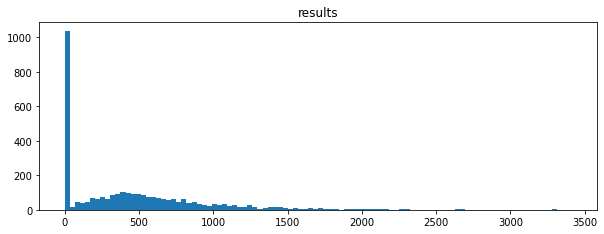

In [ ]:

#plt.subplots(nrows=len(cols_inputs))
for i in range(len(cols_inputs)):
  plt.figure(figsize= (10,20))
  plt.subplot(len(cols_inputs), 1,  i+1)
  plt.hist(np.array(inputs_lens_w)[:,i], bins=100)
  plt.title(cols_inputs[i] ) #'inputs_lens_w')
  plt.show()

In [ ]:
print(max(np.array(inputs_lens_w)[:,0]))
[max(np.array(inputs_lens_w)[:,i]) for i in range(5)]

312


[312, 3736, 4489, 4350, 3414]

In [ ]:
targets.shape, inputs.shape, inputs_concat.shape

((3200,), (3200, 5), (3200,))

###  Длины последовательностей на входе выходе
Исходя из анализа данных установим следующие


In [ ]:
# для 1-го прогона
max_word_len_inputs = 200
max_word_len_targets = 200

### Save Load Data

In [ ]:
# Save
import pickle
with open(pathNameTrain + prefix + 'targets', 'wb') as handle:
  pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'inputs', 'wb') as handle:
  pickle.dump(inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'inputs_concat', 'wb') as handle:
  pickle.dump(inputs_concat, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [ ]:
# Load
import pickle
with open(pathNameTrain + prefix + 'targets', 'rb') as handle:
  targets = pickle.load(handle)
with open(pathNameTrain + prefix + 'inputs', 'rb') as handle:
  inputs = pickle.load(handle)
with open(pathNameTrain + prefix + 'inputs_concat', 'rb') as handle:
  inputs_concat = pickle.load(handle)
  

In [ ]:
import unicodedata
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
    
def normalize_string(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^А-Яа-я.!?<>]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

In [ ]:
# Нормализуем тексты, добавляем тэги и делим targets на вход и выход декодера
%%time
inputs_concat2 = [normalize_string(str(data))[:max_word_len_inputs] for data in inputs_concat]
targets_in = ['<start> ' + normalize_string(str(data))[:max_word_len_targets-1] for data in targets]
targets_out = [normalize_string(str(data))[:max_word_len_targets-1] + ' <end>' for data in targets]

CPU times: user 17.1 s, sys: 169 ms, total: 17.3 s
Wall time: 17.2 s


# Небольшое отступление - Проверяем Transformers T5 на русском языке

In [ ]:
!pip install transformers 
!pip install sentencepiece

##Model

In [ ]:
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

## Summarization 1

In [ ]:
text ="summarize: " + ' '.join(inputs[0])
text

'summarize: Ранняя послеоперационная реабилитация и ее отдаленные функциональные результаты у пациентов с опухолями аксиального скелета  Метастатическое поражение костной системы занимает третье место по частоте после метастазов в легкие и печень. В структуре самой костной патологии метастатические опухоли встречаются в 35–40 раз чаще, чем первичные. По частоте поражения отделов костной системы на первом месте (70%) стоит поражение позвоночника и костей таза, на втором месте – поражение длинных трубчатых костей, которое составляет 30%. В длинных трубчатых костях чаще вторичный процесс локализуется в проксимальном отделе бедренной кости – до 28%, в верхней конечности и плечевом суставе – у 10–15% пациентов [1]. В настоящее время успехи в современном лекарственном лечении онкологических больных позволили значительно увеличить продолжительность жизни. Это обуславливает необходимость проведения полноценной комплексной реабилитации для этой категории пациентов. Если лечение при метастатичес

In [ ]:
text ="summarize: " + ' '.join(inputs[0])

preprocess_text = text.strip().replace("\n","").replace("\t","")
import re
#preprocess_text = re.sub("[^A-Za-z][\[0-9]]"," ", preprocess_text )
preprocess_text = re.sub("[^А-Яа-я]"," ", preprocess_text )
#preprocess_text = preprocess_text.replace("[","").replace("]","")
print(preprocess_text)


           Ранняя послеоперационная реабилитация и ее отдаленные функциональные результаты у пациентов с опухолями аксиального скелета  Метастатическое поражение костной системы занимает третье место по частоте после метастазов в легкие и печень  В структуре самой костной патологии метастатические опухоли встречаются в       раз чаще  чем первичные  По частоте поражения отделов костной системы на первом месте       стоит поражение позвоночника и костей таза  на втором месте   поражение длинных трубчатых костей  которое составляет      В длинных трубчатых костях чаще вторичный процесс локализуется в проксимальном отделе бедренной кости   до      в верхней конечности и плечевом суставе   у        пациентов      В настоящее время успехи в современном лекарственном лечении онкологических больных позволили значительно увеличить продолжительность жизни  Это обуславливает необходимость проведения полноценной комплексной реабилитации для этой категории пациентов  Если лечение при метастатическ

In [ ]:
tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)


# summmarize 
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=30,
                                    max_length=200,
                                    early_stopping=True)

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(output)

аиентов на уровне и методоени дл своственне раотатс в неомоности.


Вывод
1. Transformers T5 ожидаемо  не сработал 

# Prepare Dataset

In [ ]:
# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 20
# v1 сделаем пока маленьким и одинаковым для входа и выхода - для проверки
SEQ_LENGTH = max_word_len_inputs # (max_word_len_targets)= 200

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512
HIDDEN_DIM = EMBED_DIM

# Number of self-attention heads
NUM_HEADS = 2
H = 2
NUM_LAYERS = 1

BATCH_SIZE = 20

In [ ]:
%%time
filters_default ='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
filters_correct ='!"#$%&()*+-/:;=?@[\\]^_`{|}~\t\n'
# убрали '.', ',', '<', '>'
in_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= VOCAB_SIZE, 
                                                     #filters='', 
                                                     filters=filters_correct, 
                                                     oov_token="unknown")
in_tokenizer.fit_on_texts(inputs_concat2)
data_inputs = in_tokenizer.texts_to_sequences(inputs_concat2)
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, 
                                                        #maxlen=SEQ_LENGTH,
                                                        maxlen=max_word_len_inputs,
                                                        padding='post')

tar_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, 
                                                      #filters='', 
                                                      filters=filters_correct,
                                                      oov_token="unknown")
tar_tokenizer.fit_on_texts(targets_in)
tar_tokenizer.fit_on_texts(targets_out)
data_targets_in = tar_tokenizer.texts_to_sequences(targets_in)
data_targets_in = tf.keras.preprocessing.sequence.pad_sequences(data_targets_in, 
                                                          #maxlen=SEQ_LENGTH,
                                                          maxlen=max_word_len_targets,
                                                          padding='post')

data_targets_out = tar_tokenizer.texts_to_sequences(targets_out)
data_targets_out = tf.keras.preprocessing.sequence.pad_sequences(data_targets_out, 
                                                          #maxlen=SEQ_LENGTH,
                                                          maxlen=max_word_len_targets,
                                                          padding='post')

CPU times: user 803 ms, sys: 0 ns, total: 803 ms
Wall time: 804 ms


In [ ]:
%%time
dataset = tf.data.Dataset.from_tensor_slices(
    (data_inputs, data_targets_in, data_targets_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)

CPU times: user 4.65 ms, sys: 0 ns, total: 4.65 ms
Wall time: 3.63 ms


In [ ]:
print(list(dataset.take(1))[0])

In [ ]:
def positional_embedding(pos, hidden_dim):
    PE = np.zeros((1, hidden_dim))
    for i in range(hidden_dim):
        if i % 2 == 0:
            PE[:, i] = np.sin(pos / 10000 ** (i / hidden_dim))
        else:
            PE[:, i] = np.cos(pos / 10000 ** ((i - 1) / hidden_dim))
    return PE

# max_length = max(len(data_en[0]), len(data_fr_in[0]))
# max_length = SEQ_LENGTH 
max_length = max(max_word_len_inputs, max_word_len_targets)

pes = []
for i in range(max_length):
    pes.append(positional_embedding(i, HIDDEN_DIM))

pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32)
pes.shape

TensorShape([200, 512])

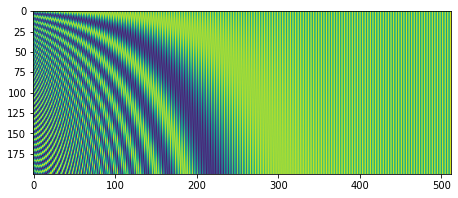

In [ ]:
plt.figure(figsize=(10,3))
plt.imshow(pes.numpy())
plt.show()

# Create Model

In [ ]:
H = 2
NUM_LAYERS = 1
HIDDEN_DIM = EMBED_DIM # 128
in_vocab_size =  len(in_tokenizer.word_index) + 1
tar_vocab_size = len(tar_tokenizer.word_index) + 2
print('Input vocabulary size', in_vocab_size)
print('Target vocabulary size', tar_vocab_size)

Input vocabulary size 15222
Target vocabulary size 15392


In [ ]:
in_vocab_size = VOCAB_SIZE
tar_vocab_size = VOCAB_SIZE
print('Input vocabulary size', in_vocab_size)
print('Target vocabulary size', tar_vocab_size)

Input vocabulary size 10000
Target vocabulary size 10000


### MultiHeadAttention

In [ ]:
class MultiHeadAttention(tf.keras.Model):
    def __init__(self, hidden_dim, h):
        super(MultiHeadAttention, self).__init__()
        self.key_size = hidden_dim // h
        self.h = h
        self.wq = tf.keras.layers.Dense(hidden_dim) #замена [tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wk = tf.keras.layers.Dense(hidden_dim) #замена [tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wv = tf.keras.layers.Dense(hidden_dim) #замена [tf.keras.layers.Dense(value_size) for _ in range(h)]
        self.wo = tf.keras.layers.Dense(hidden_dim)
    
    def call(self, decoder_output, encoder_output, mask=None):
        
        
        query = self.wq(decoder_output)
        key = self.wk(encoder_output)
        value = self.wv(encoder_output)
        
        # Разделяем для multihead attention
        batch_size = query.shape[0]
        query = tf.reshape(query, [batch_size, -1, self.h, self.key_size])
        query = tf.transpose(query, [0, 2, 1, 3])
        key = tf.reshape(key, [batch_size, -1, self.h, self.key_size])
        key = tf.transpose(key, [0, 2, 1, 3])
        value = tf.reshape(value, [batch_size, -1, self.h, self.key_size])
        value = tf.transpose(value, [0, 2, 1, 3])
        
        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(tf.dtypes.cast(self.key_size, dtype=tf.float32))
        
        if mask is not None:
            score *= mask
            score = tf.where(tf.equal(score, 0), tf.ones_like(score) * -1e9, score)
        
        a = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(a, value)
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, [batch_size, -1, self.key_size * self.h])
        
        heads = self.wo(context)
        return heads

## Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, hidden_dim, num_layers, h):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_dim)
        self.attention = [MultiHeadAttention(hidden_dim, h) for _ in range(num_layers)]

        self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

        self.dense_1 = [tf.keras.layers.Dense(512, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(hidden_dim) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

    def call(self, sequence, padding_mask=None):
        embed_out = self.embedding(sequence)
        # ускорение применяем embeding сразу ко всем без цикла 
        embed_out += pes[:sequence.shape[1], :]
        
        # Средний блок внимания - внимание на себя с макировкой
        sub_in = embed_out
        
        # маскирование на остаток не слов и они вляить не будут
        for i in range(self.num_layers):
            sub_out = self.attention[i](sub_in, sub_in, padding_mask)
            sub_out = sub_in + sub_out
            sub_out = self.attention_norm[i](sub_out)
            
            ffn_in = sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = ffn_in + ffn_out
            ffn_out = self.ffn_norm[i](ffn_out)

            sub_in = ffn_out
            
        return ffn_out

## Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, hidden_dim, num_layers, h):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_dim)
        self.attention_bot = [MultiHeadAttention(hidden_dim, h) for _ in range(num_layers)]
        self.attention_bot_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        self.attention_mid = [MultiHeadAttention(hidden_dim, h) for _ in range(num_layers)]
        self.attention_mid_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.dense_1 = [tf.keras.layers.Dense(512, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(hidden_dim) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, sequence, encoder_output, padding_mask=None):
        # Эмбеддинги
        embed_out = self.embedding(sequence)
        embed_out += pes[:sequence.shape[1], :]
        
        bot_sub_in = embed_out
        # неt циrлла по головам (есть доп ось по -кой все вычисляется) и есть маскирование
        # маска генерится во время обучниея
        for i in range(self.num_layers):
            # Нижний блок внимания
            # Нижний блок внимания - типа(?)  внимание на себя
            seq_len = bot_sub_in.shape[1]
            look_left_only_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            bot_sub_out = self.attention_bot[i](bot_sub_in, bot_sub_in, look_left_only_mask)
            bot_sub_out = bot_sub_in + bot_sub_out
            bot_sub_out = self.attention_bot_norm[i](bot_sub_out)
            
            # Верхний блок внимания
            # я - Средний блок внимания - внимание на себя с макировкой
            mid_sub_in = bot_sub_out

            mid_sub_out = self.attention_mid[i](mid_sub_in, encoder_output, padding_mask)
            mid_sub_out = mid_sub_out + mid_sub_in
            mid_sub_out = self.attention_mid_norm[i](mid_sub_out)

            # Полносвязный слой
            ffn_in = mid_sub_out

            # FeedForward (сеть с прямой связью)
            # Feedforward neural networks are also known as Multi-layered Network of Neurons (MLN)
            # https://medium.com/hackernoon/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = ffn_out + ffn_in
            ffn_out = self.ffn_norm[i](ffn_out)

            bot_sub_in = ffn_out
        
        logits = self.dense(ffn_out)
            
        return logits

## Loss

In [ ]:
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
def loss_func(targets, logits):
    # дополнительное маскирование
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
  
    return loss


optimizer = tf.keras.optimizers.Adam()

## Predict - functional

In [ ]:
tar_tokenizer.word_index['<start>'], tar_tokenizer.word_index['<end>']

(5, 6)

In [ ]:
def predict(test_source_text=None):
    if test_source_text is None:
        test_source_text = inputs_concat2[np.random.choice(len(inputs_concat2))]
    print(test_source_text)
    test_source_seq = in_tokenizer.texts_to_sequences([test_source_text])
    test_source_seq = tf.keras.preprocessing.sequence.pad_sequences(test_source_seq, 
                                                        #maxlen=SEQ_LENGTH,
                                                        maxlen=max_word_len_inputs,
                                                        padding='post')
    #print(test_source_seq)

    en_output = encoder(tf.constant(test_source_seq))

    de_input = tf.constant([[tar_tokenizer.word_index['<start>']]], dtype=tf.int64)
    #de_input = tf.constant([[tar_tokenizer.word_index['start']]], dtype=tf.int64)
    # надо попроавить фильтр tar_tokenizer, чтобы не удалял '<' '>'

    out_words = []

    while True:
        de_output = decoder(de_input, en_output)
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(tar_tokenizer.index_word[new_word.numpy()[0][0]])

        de_input = tf.concat((de_input, new_word), axis=-1)

        if out_words[-1] == '<end>' or len(out_words) >= max_word_len_targets: #14
        #if out_words[-1] == 'end' or len(out_words) >= max_word_len_targets: #14
            # надо попроавить фильтр tar_tokenizer, чтобы не удалял '<' '>'
            break

    print((' '.join(out_words)).replace("<end>",""))
    return (' '.join(out_words)).replace("<end>","")

## Train step

In [ ]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    with tf.GradientTape() as tape:
        padding_mask = 1 - tf.cast(tf.equal(source_seq, 0), dtype=tf.float32)
        padding_mask = tf.expand_dims(padding_mask, axis=1)
        padding_mask = tf.expand_dims(padding_mask, axis=1)
        encoder_output = encoder(source_seq, padding_mask)
        
        decoder_output = decoder(target_seq_in, encoder_output, padding_mask)

        loss = loss_func(target_seq_out, decoder_output)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

## Params for model - w

In [ ]:
in_vocab_size, tar_vocab_size, VOCAB_SIZE, H, NUM_LAYERS, HIDDEN_DIM, EMBED_DIM 

(10000, 10000, 10000, 2, 1, 512, 512)

In [ ]:
print(list(dataset.take(1))[0])
dataset.take(1) 

In [ ]:
encoder = Encoder(in_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)

in_sequence_in = tf.constant([[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20], 
                           [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20]])

#in_sequence_in = list(dataset.take(1))[0][0][0]
encoder_output = encoder(in_sequence_in)


print('Encoder input shape', in_sequence_in.shape)
print('Encoder output shape', encoder_output.shape)

max_len_out = data_targets_in .shape[1]
decoder = Decoder(tar_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)

tar_sequence_in = tf.constant([[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20], 
                           [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20]])
decoder_output = decoder(tar_sequence_in, encoder_output)


print('Decoder input shape', tar_sequence_in.shape)
print('Decoder output shape', decoder_output.shape)

Encoder input shape (2, 19)
Encoder output shape (2, 19, 512)
Decoder input shape (2, 19)
Decoder output shape (2, 19, 10000)


In [ ]:
in_vocab_size, tar_vocab_size, HIDDEN_DIM, NUM_LAYERS, H

(10000, 10000, 512, 1, 2)

# Train Model

In [ ]:
encoder = Encoder(in_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)
decoder = Decoder(tar_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)

NUM_EPOCHS = 100

start_time = time.time()
for e in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        loss = train_step(source_seq, target_seq_in,
                          target_seq_out)

    print('Epoch {} Loss {:.8f}'.format(
          e + 1, loss.numpy()))

    if (e + 1) % 10 == 0:
        end_time = time.time()
        print('Среднее время: {:.2f}s'.format((end_time - start_time) / (e + 1)))
        try:
            predict()
        except Exception as e:
            print(e)
            continue

Epoch 1 Loss 0.62222189
Epoch 2 Loss 0.45653942
Epoch 3 Loss 0.42423847
Epoch 4 Loss 0.38882247
Epoch 5 Loss 0.38367742
Epoch 6 Loss 0.35938340
Epoch 7 Loss 0.26444551
Epoch 8 Loss 0.25546756
Epoch 9 Loss 0.23607665
Epoch 10 Loss 0.21291760
Среднее время: 27.85s
КАРТИРОВАНИЕ И КАТЕТЕРНАЯ АБЛАЦИЯ ИНЦИЗИОННЫХ СУПРАВЕНТРИКУЛЯРНЫХ НАРУШЕНИИ РИТМА У ПАЦИЕНТОВ ДЕТСКОГО И ЮНОШЕСКОГО ВОЗРАСТА В последние годы в нашеи стране значительно увеличились объем и количество 
[[5728, 3, 5544, 1829, 1, 1, 89, 131, 5, 12, 727, 3, 4651, 54, 2, 39, 77, 2, 1319, 1320, 851, 1, 1787, 3, 464]]
целью работы было изучение эффективности лечения первичнои unknown unknown unknown unknown unknown unknown unknown unknown unknown объемов . материалы и методы . в исследование включены б 
Epoch 11 Loss 0.23473224
Epoch 12 Loss 0.20785791
Epoch 13 Loss 0.15708867
Epoch 14 Loss 0.17512916
Epoch 15 Loss 0.16817644
Epoch 16 Loss 0.15053573
Epoch 17 Loss 0.17351036
Epoch 18 Loss 0.12062635
Epoch 19 Loss 0.11934403
Epoch 20 L

# Predict

In [ ]:
#test_sents = inputs[:20]
test_sents = inputs_concat[:20]

for i, test_sent in enumerate(test_sents):
    test_sequence = normalize_string(test_sent)
    text_predict = predict(test_sequence)
    print("orginal: ", targets[i])
    print()

ОСОБЕННОСТИ ТЕЧЕНИЯ ОСТРЫХ РЕСПИРАТОРНЫХ ЗАБОЛЕВАНИИ У БОЛЬНЫХ С АТОПИЯМИ Острые респираторные заболевания ОРЗ представляют собои большую этиологически разнородную группу инфекционных болезнеи протекающих с поражением верхних дыхательных путеи трахеи и бронхов характеризующихся определенным сходством патогенеза и клинических проявлении . В большинстве случаев респираторные заболевания обусловлены вируснои инфекциеи . Медицинское и социально экономическое значение этои патологии определяется масштабами распространенности и ее активнои ролью в патогенезе многочисленных осложнении со стороны различных органов и систем . Одним из факторов риска рецидивов острых респираторных заболевании и более тяжелого ее течения является аллергия . Аллергические заболевания представляют одну из трудноразрешимых и актуальных задач современнои медицины . Мировая статистика доказывает стремительныи рост такои патологии до . Сегодня каждыи пятыи житель на Земле страдает какои либо формои атопическои патологи

# Выводы
1. Загрузил и рапарсил файлы .xlsx и новой структуы .ods
2. Подготовил данные для модели
3. Создал модель Transformer (ускоренную) и провел ее обучение с парамтерами:
- 3200 записей - полный набор считанных файлов
- VOCAB_SIZE = 10000 (для inputs и  targets данных)
- HIDDEN_DIM = 512
- SEQ_LEN = 200 (для простоты 1-го прогона - для inputs и  targets данных)
- HEADS = 2
- NUM_LAYERS = 1
- EPOCHS = 100
- Получил точность по LOSS - 0.0150 - на последних эпохах (не 0.0001 на 40-ка записях, но тоже неплохо)
4. Сделал Predict - сетка часто выдает более менее вразумительные ответы (в seq2seq ботах (без внимания) бло гораздо хуже
5. Turning - не задача данного задания. Хорошо, что прошел полный цикл

**Мне понравилась архитектура**